Superposition of cross correlations of 100 Randomized Sources

In [2]:
# %reset -f
# globals().clear()  

PACKAGES

In [24]:
import numpy as np
from numpy import linalg
from examples.seismic import Model, plot_velocity,TimeAxis,RickerSource,Receiver,plot_shotrecord
from devito import TimeFunction,Eq, solve,Operator,Grid
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import math
import random 

THE X-Y PLANE MODEL, RANDOMIZED SEEDS AND INITIALIZATIONS

In [25]:
# ................................................ MODEL
# Number of grid points in 2D (nx, nz) (201 points in both x and y directions )
shape = (201, 201)
# Grid spacing in m (spatial resolution Meaning each of those 201 points on the grid represents a physical space of 10m in both x and y directions)
spacing = (10., 10.)
# location of the top left corner
origin = (0., 0.)
# Velocity profile (in km/s) (empty array size of "shape" with everything of type 32 bit float) 
v = np.empty(shape, dtype=np.float32)
# homogenous media - this sets all elements of the array v to 1.5 km/s (not all media are homogenous)
v[:, :] = 1.5 
# # half different media 
# v[:, 51:] = 2.5

# Seismic model that represents the physical properties of the medium defined above, through which the waves propogate. Overall model for wave propogation simulations. 
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, space_order=2, nbl=100, bcs="damp")
# ................................................ TIME #TODO: Fix all comments below this point 
#TODO: delayed time 
# time parameters for the simulation
t0 = 0.  # Simulation starts a t=0
tn = 1000.  # end time: Simulation lasts 1000 ms (1 second) 
dt =  model.critical_dt  #Time step from model whos cirital value is based on grid spacingand physics properties defined by the model. the critcal time step ensures stability of the numerical solution for finite difference methods 
time_range = TimeAxis(start=t0, stop=tn, step=dt) #defines time range for simulation, starting at t0 and ending at tn with increments of dt. Time axis object us used to iterate through time steps durign simulation 
time_values = time_range.time_values
time_steps = len(time_values) #how many steps are needed for the loop later on 
# ................................................ INITITALIZING RANDOM SEEDS 
num_sources = 300 #(eventually do 100)
# time parameters for the simulation
#empty start times #timing (start times at moments so it could propogate through all recievers before time window is up - may need to tripple check this after)
# start_times = np.empty((num_sources)) #30 different start times avaiable
# time_steps = np.empty((num_sources))
# for i in range(num_sources):
#     random.seed(i)

#     start_time = random.randint(0, 200) #random start time between 0 second and 200 seconds ms
    
#     start_times[i] = start_time

#Random Angle 
angles = np.empty((num_sources)) 
for i in range(num_sources):
    angle = random.randint(0,360) #random angle
    # Angle in radians
    angle_radians = math.radians(angle)

    angles[i] = angle_radians

#Random Radius in Annulus 
radii = np.empty((num_sources)) 
for i in range(num_sources):
    radius = random.randint(400, 700) 
    #radius more than 400 m from the center of the grid and less than 700 m from the center of the grid 
    #(also the middle reciever, who's entire line is 400m long about the center). 
    #The radius being larger than 400 allows for 200m between last reciever and closest possible source. 
    #Ending at 700m allows for a 300m padding before the edge of the grid. 
    radii[i] = radius

# Converting to Cartesian
sources_x = np.empty((num_sources))
sources_y = np.empty((num_sources))
for i in range(num_sources):
    sources_x[i] = radii[i]*math.cos(angles[i])+1000 #plus 1000 so that it's centered around there because the grid is 2000
    sources_y[i] = radii[i]*math.sin(angles[i])+1000

# Source peak frequency 
frequencies = np.empty((num_sources)) #30 different start times avaiable
for i in range(num_sources):
    frequency = random.randint(1, 20) #random frequenxy between 1 and 20 hz
    frequency = frequency*0.001 #The program takes in khz but we want 20 hz so multiplying by 0.001 
    frequencies[i] = frequency

#................................................... RECIEVERS
# number of receivers
num_rec = 40
# create receiver object 
rec = Receiver(name='rec', grid=model.grid, npoint=num_rec, time_range=time_range)
# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(800, 1200, num=num_rec) #starting at 800 km and ending at 1200 km units 
rec.coordinates.data[:, 1] = 1000.  # Depth is 500 units for all recievers 
#.................................................INITIALIZING 
# empty arrays to be filled by loops 
shot_gathers = np.empty((num_sources,time_steps,num_rec)) # bandpasses of interest #frequencies = [(0,10),(5,15),(10,20),(0,20)]
noisy_seismic_data = np.empty((time_steps,num_rec), dtype=np.float32)
normalized_gathers = np.empty((time_steps,num_rec), dtype=np.float32)

all_U = np.empty((time_steps,time_steps))
all_Vh = np.empty((num_rec,num_rec))
all_s = np.empty((num_rec,num_rec))
all_B = np.empty((num_sources,time_steps,num_rec))

cross_correlation_results_with_distance = np.empty((num_rec,num_rec,num_rec**2,time_steps))
distance_between = np.empty((num_rec,num_rec))
distance_between_index = np.empty((num_rec,num_rec))

cross_correlation_results = np.empty((num_sources,num_rec,num_rec,time_steps))# cross_correlation_results = np.empty((sources.size,len(frequencies),num_rec,num_rec,time_steps+2))
cross_correlation_results_postSVD = np.empty((num_sources,num_rec,num_rec,time_steps))
noisy_seismic_data =np.empty((num_sources,time_steps,num_rec))


Operator `initdamp` ran in 0.01 s


WAVE RESPONSE

In [83]:
dt = float(dt)
#................................................ LOOPS BEGIN
for i in range(20):
    f0 = frequencies[i]  # 10Hz (0.010 kHz). it determines the characteristics of the emitted wavelet 
    # the simulations source 
    src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
    src.coordinates.data[0,0] = sources_x[i] #x position of source
    src.coordinates.data[0,1] = sources_y[i] #y position of source 
    # Time dependent function u that represents the wavefield (it's the solution to the wave equation)
    u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)
    # Write the PDE
    pde = model.m * u.dt2 - u.laplace + model.damp * u.dt # Model.m (1/vp(x,y)) is predefined parameter, as is model.damp: damp(x,y)
    # set of discrete points used to approcimate the derivitives in the PDE. "discrete update rule for wavefield u"
    stencil = Eq(u.forward, solve(pde, u.forward)) #using finite differences where we replace continuous derivatives with discrete approximations based on values at neighboring grid points.
    # Define source injection
    src_term = src.inject(field=u.forward, expr=src * (dt**2) / model.m)
    # Create interpolation expression for receivers
    rec_term = rec.interpolate(expr=u.forward) #receiver read function 
    # Combine everyting into a single operator that can be executed to solve the PDE
    op = Operator([stencil] + src_term + rec_term, subs={key: float(value) for key, value in model.spacing_map.items()}) #substituted grid spacing into the parameters 
    op(time=time_range.num-1, dt=model.critical_dt) #runs operator for specified time range and steop (time is all the way the end of time simulations, and time step is defined)
    
    # Noise 
    noise_amplitude = np.max(rec.data) * 0.02  # noise amplitude that's 2% highest freq 
    noise = noise_amplitude * np.random.randn(rec.data.shape[0], rec.data.shape[1])
    shot_gathers[i,:,:] = rec.data + noise
    #................................................ NORMALIZING SO MAX VALUE OF EACH SOURCE IS SAME PRE SVD
    # normalize with noise 
    normalized_data = shot_gathers[i,:,:] / np.linalg.norm(shot_gathers[i,:,:])
    shot_gathers[i,:,:] = normalized_data



Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.15 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.03 s


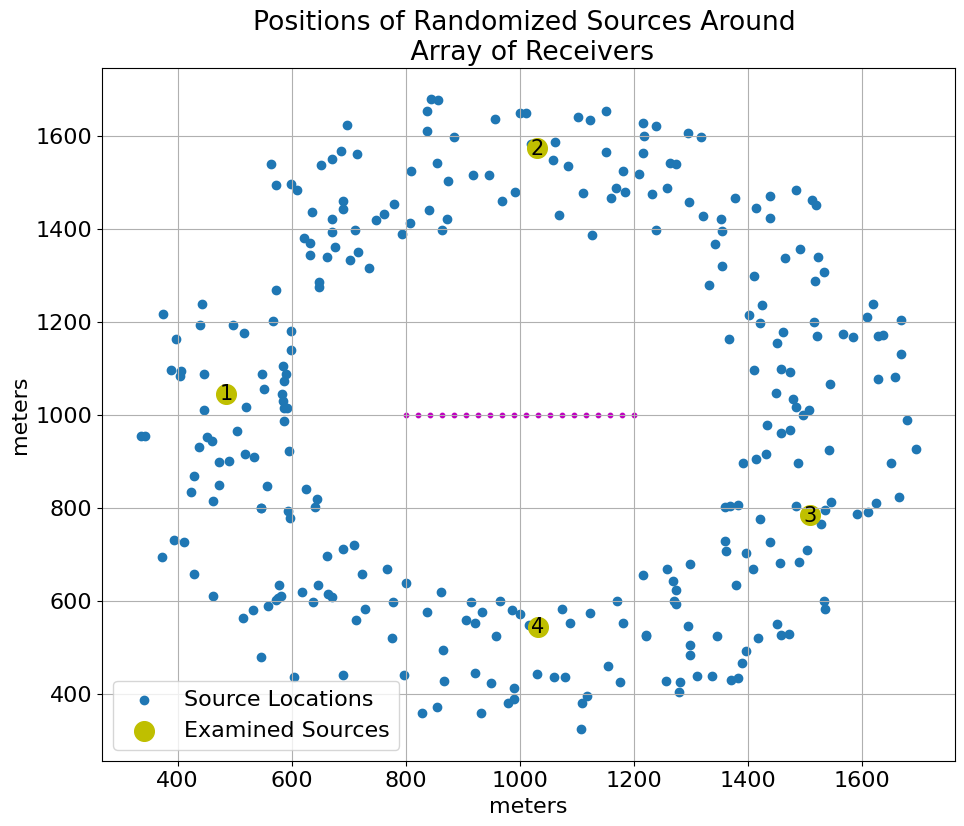

In [102]:
# colors = plt.cm.Greys(np.linspace(0.3, 0.9, len(sources_x[0:20])))  # Avoid pure black/white

plt.figure(figsize=(11, 9))

plt.scatter(sources_x,sources_y, marker='o',label ='Source Locations')

plt.scatter(sources_x[13],sources_y[13],c = 'y', s = 200,  marker='o')
plt.text(sources_x[13],sources_y[13], '1', color='black', fontsize=15, ha='center', va='center')

plt.scatter(sources_x[4],sources_y[4],c = 'y', s = 200,  marker='o')
plt.text(sources_x[4],sources_y[4], '2', color='black', fontsize=15, ha='center', va='center')

plt.scatter(sources_x[10],sources_y[10], c = 'y', s = 200,marker='o', label = 'Examined Sources')
plt.text(sources_x[10],sources_y[10], '3', color='black', fontsize=15, ha='center', va='center')

plt.scatter(sources_x[1],sources_y[1],c = 'y', s = 200,  marker='o')
plt.text(sources_x[1],sources_y[1], '4', color='black', fontsize=15, ha='center', va='center')

plt.scatter(np.linspace(800,1200,20),np.linspace(1000,1000,20),c = 'm',s = 10)

plt.title("Positions of Randomized Sources Around \n Array of Receivers")
plt.xlabel('meters')
plt.ylabel('meters')
plt.legend() 
plt.grid()
plt.show()

In [7]:
# # For visualizing the random seeds 
# plt.scatter(np.arange(len(frequencies)),frequencies,marker='o')
# plt.show()

CROSS CORRELATIONS AND SVD 

In [84]:
all_B = np.empty((num_sources,time_steps,num_rec))
#................................................ CROSS CORRELATION
for i in range(20):
    # for j in range(0,num_rec):
    #     for k in range(0, num_rec):
    #         correlation = correlate(shot_gathers[i,:,j], shot_gathers[i,:,k], mode='same',method='auto') #just doing first source right now 
    #         cross_correlation_results[i,j,k,:] = correlation
# ............................................... SVD 
    [U,s,Vh] = np.linalg.svd(shot_gathers[i,:,:], full_matrices=True, compute_uv=True, hermitian=False) #all should be real valued becasue the filtered shot gathers are
    s_diag = np.diag(s)
    k = 10#20% singvals
    B = (U[:,0:k]@s_diag[0:k,0:k])@Vh[0:k,:] #reconstruction
    all_B[i,:,:] = B
    # #................................................. CROSS CORRELATION POST SVD
    # for m in range(0,num_rec):
    #     for n in range(0, num_rec):
    #         correlation = correlate(B[:,m], B[:,n], mode='same',method='auto') #just doing first source right now 
    #         cross_correlation_results_postSVD[i,m,n,:] = correlation


visualize a few shot plots and SVD

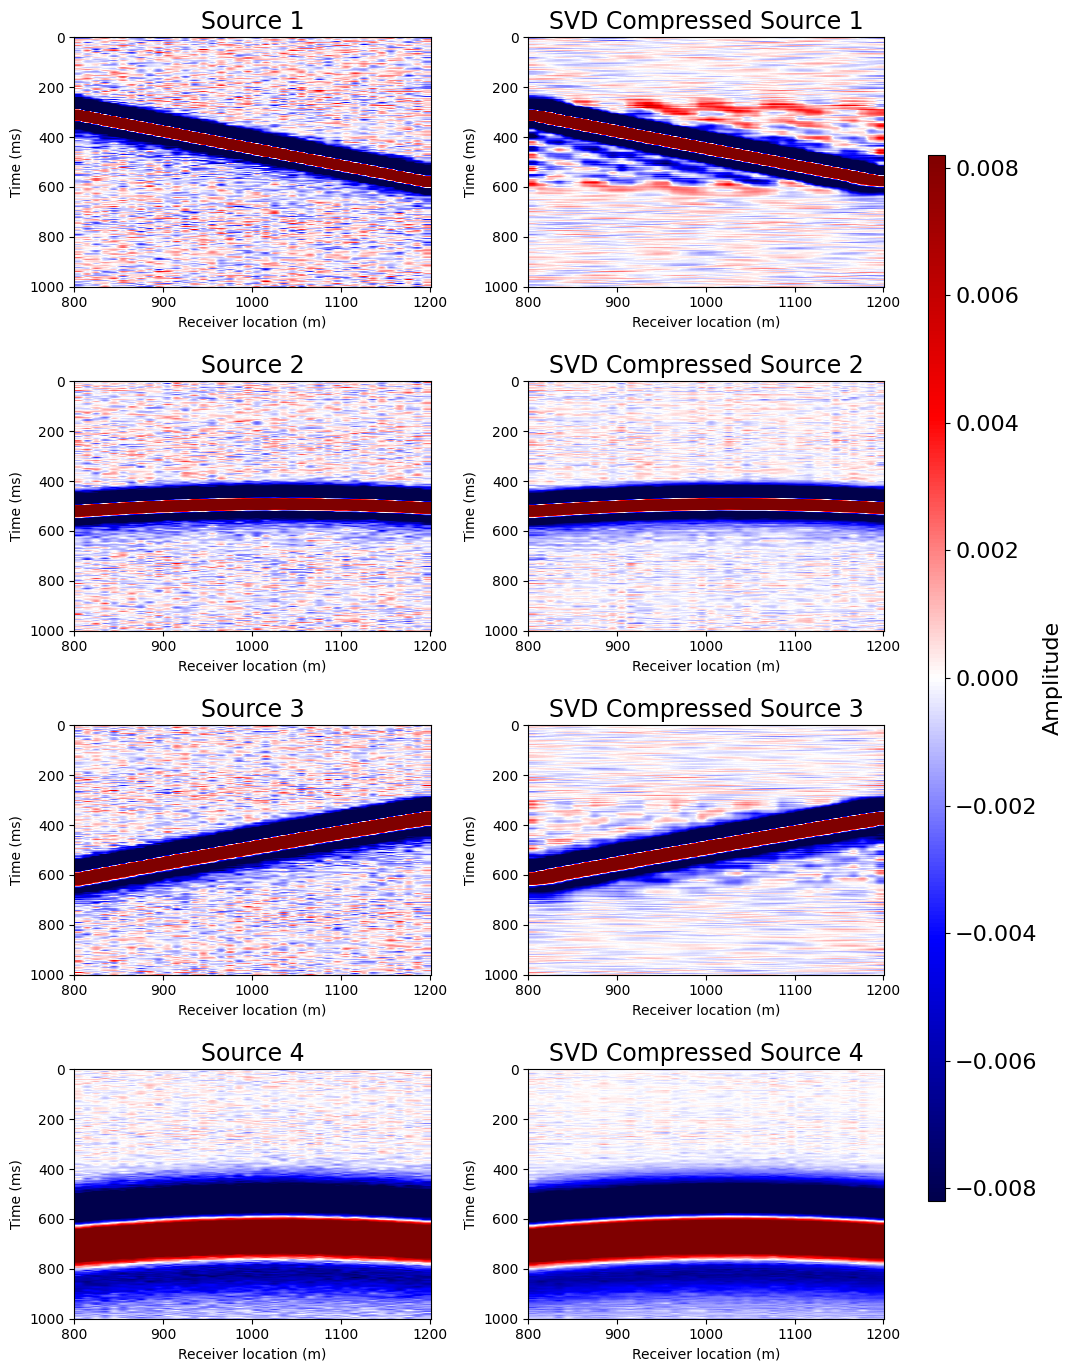

In [101]:
clip = np.percentile(np.absolute(shot_gathers),99)
nrows = 4
ncols = 2

y = np.array([shot_gathers[13,:,:],shot_gathers[4,:,:],shot_gathers[10,:,:],shot_gathers[1,:,:],
              all_B[13,:,:],all_B[4,:,:],all_B[10,:,:],all_B[1,:,:]])
count = 0
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 14))  # Adjust figsize as needed
im = None
for j in range(ncols):
    for i in range(nrows):
        # Plotting the data
        im = axs[i, j].imshow(y[count], aspect='auto',vmin=-clip, vmax=clip,cmap='seismic',extent=[800,1201,1000,0])
        axs[i, j].set_title(f'Source {count+1}',fontsize = 17)
        axs[i, j].set_xlabel('Receiver location (m)',fontsize = 10)
        axs[i, j].set_ylabel('Time (ms)', fontsize = 10)
        axs[i, j].tick_params(axis='both', which='major', labelsize=10)
        count +=1
for i in range(nrows):
    axs[i,j].set_title(f'SVD Compressed Source {i+1}',fontsize = 17)

# Adjust layout to prevent overlap
plt.tight_layout()
cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.05, shrink = 1, aspect = 60)
cbar.set_label('Amplitude')
# Show the plots
plt.show()

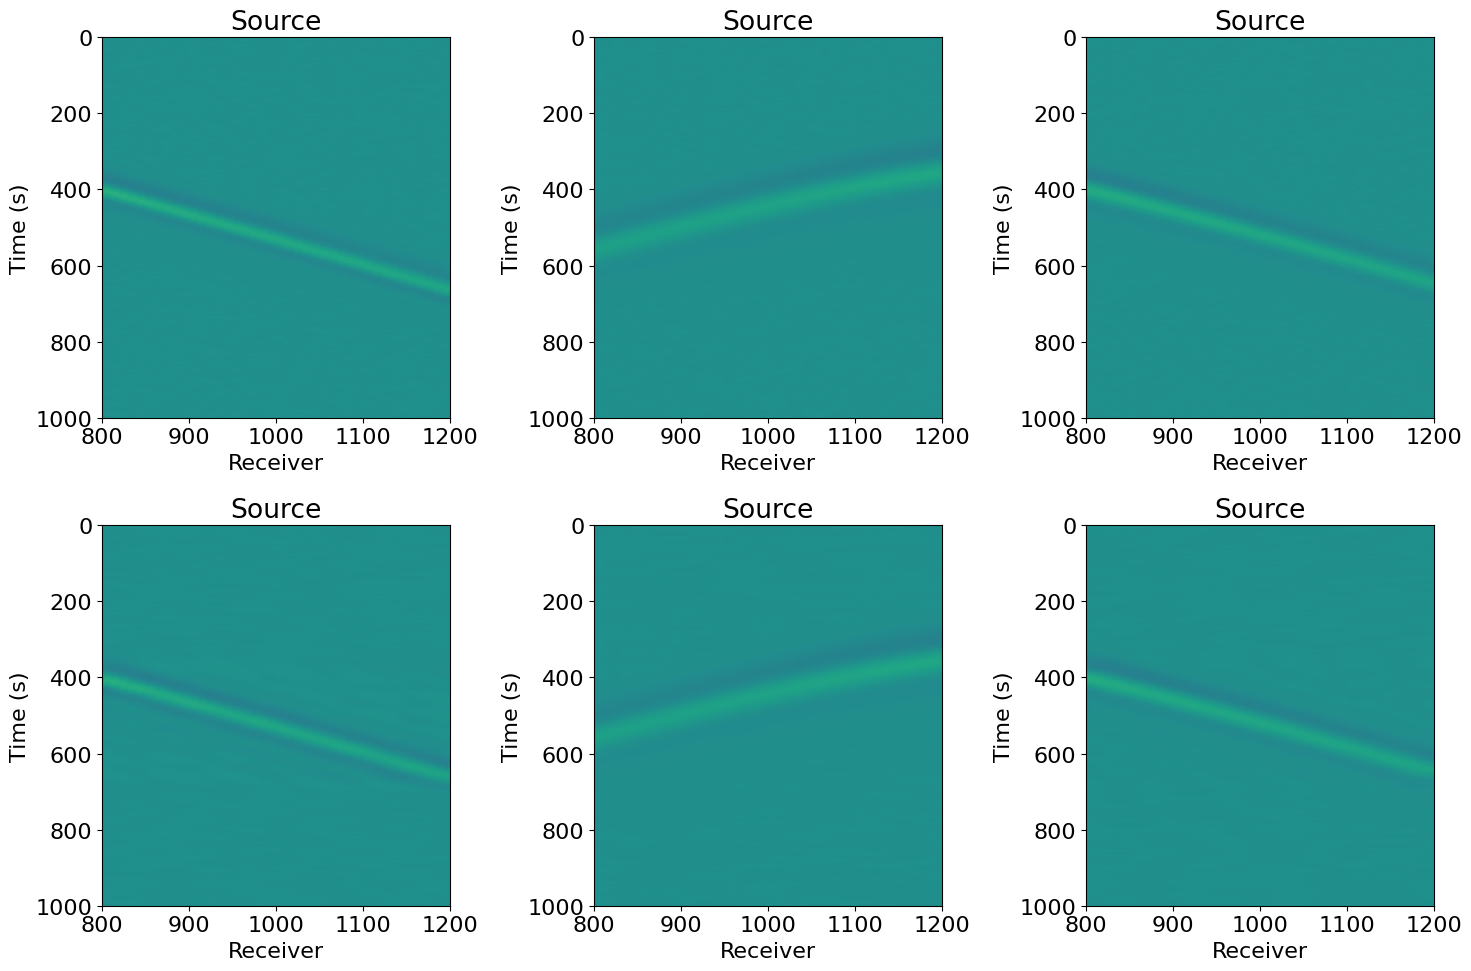

In [11]:

nrows = 2
ncols = 3
scale = np.max(rec.data) / 10.

y = np.array([shot_gathers[0,:,:],shot_gathers[1,:,:],shot_gathers[2,:,:],
              all_B[0,:,:],all_B[1,:,:],all_B[2,:,:]])
count = 0
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))  # Adjust figsize as needed

for i in range(nrows):
    for j in range(ncols):
        # Plotting the data
        axs[i,j].imshow(y[count], aspect='auto',vmin=-scale, vmax=scale,cmap='viridis',extent=[800,1201,1000,0])
        axs[i,j].set_title('Source')
        axs[i,j].set_xlabel('Receiver')
        axs[i,j].set_ylabel('Time (s)')
        count +=1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

average them 

In [11]:
r = 20 #receiver right in the middle 
sum_matrix = np.zeros((num_rec,time_steps))
averaged_cross_correlation = np.zeros((num_rec,time_steps))
for i in range(num_sources):
    sum_matrix += cross_correlation_results[i,r,:,:]
averaged_cross_correlation = sum_matrix/num_sources


sum_matrix = np.zeros((num_rec,time_steps))
averaged_cross_correlation_postSVD = np.zeros((num_rec,time_steps))
for i in range(num_sources):
    sum_matrix += cross_correlation_results_postSVD[i,r,:,:]
averaged_cross_correlation_postSVD = sum_matrix/num_sources




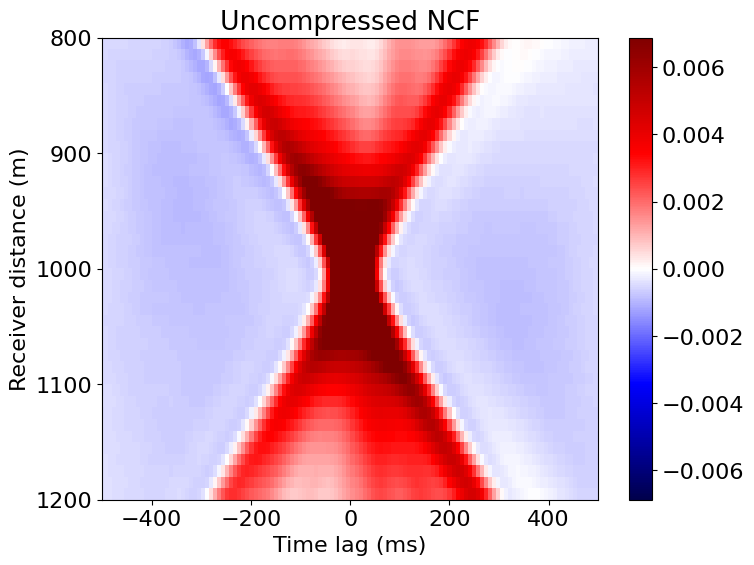

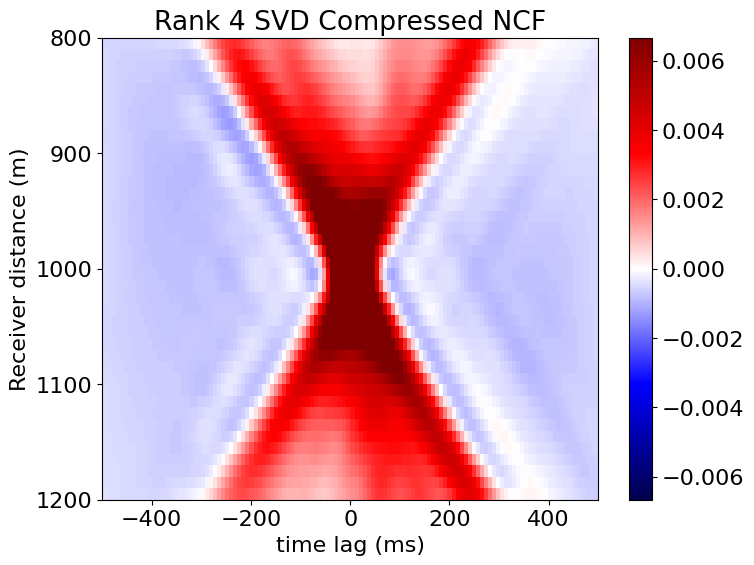

In [12]:
#plots for cross correlations 
clip = np.percentile(np.absolute(averaged_cross_correlation),98)
plt.imshow(averaged_cross_correlation,vmax=clip,vmin=-clip,aspect = 'auto',cmap = 'seismic',interpolation = 'none',extent=[-tn,tn,40,0])
plt.xlabel('Time lag (ms)')
plt.ylabel('Receiver distance (m)')
plt.title('Uncompressed NCF')
plt.xlim(-500,500)
plt.yticks( [0, 10,20,30,40],['800','900', '1000', '1100','1200'])
plt.colorbar()
plt.show()

clip = np.percentile(np.absolute(averaged_cross_correlation_postSVD),98)
plt.imshow(averaged_cross_correlation_postSVD,vmax=clip,vmin=-clip,aspect = 'auto',cmap = 'seismic',interpolation = 'none',extent=[-tn,tn,40,0])
plt.xlabel('time lag (ms)')
plt.ylabel('Receiver distance (m)')
plt.title('Rank 4 SVD Compressed NCF')
plt.yticks([0, 10,20,30,40],['800','900', '1000', '1100','1200'])
plt.xlim(-500,500)
plt.colorbar()
plt.show()



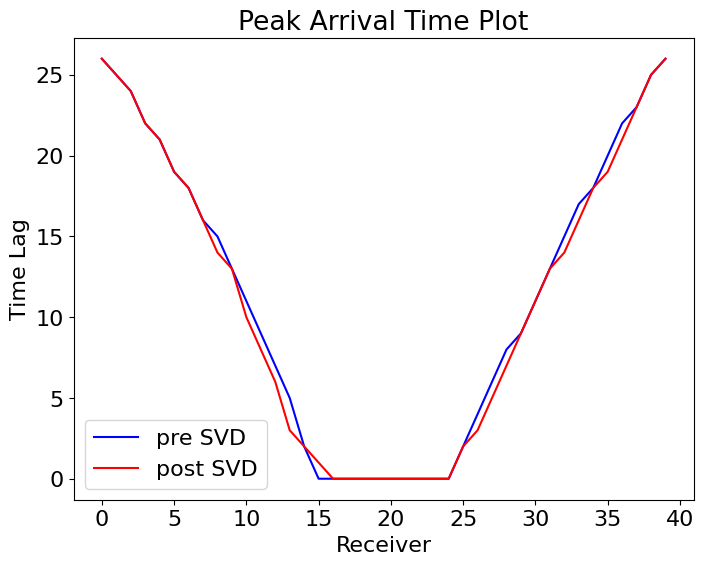

In [13]:
#r chosen above
peak_timelag = np.empty((num_rec))
peak_timelag_postSVD = np.empty((num_rec))

for l in range(num_rec):
    peak_index = np.argmax(averaged_cross_correlation[l,126:])  # Get the index of the maximum value
    # peak_value = averaged_cross_correlation[l,:][peak_index]  # Maximum value
    peak_timelag[l] = peak_index

    peak_index_postSVD = np.argmax(averaged_cross_correlation_postSVD[l,126:])  # Get the index of the maximum value
    # peak_value_postSVD = averaged_cross_correlation_postSVD[l,:][peak_index_postSVD]  # Maximum value
    peak_timelag_postSVD[l] = peak_index_postSVD






title = ('Peak Arrival Time Plot')
plt.plot(peak_timelag[:],label='pre SVD', color='blue')
plt.plot(peak_timelag_postSVD[:],label='post SVD', color='red')
plt.title(title)
plt.xlabel('Receiver')
plt.ylabel('Time Lag')
plt.legend()
plt.show()


RMSE: 0.6324555320336759
MAE: 0.35
Correlation Coefficient: 0.9981495794305922
R-Squared: 0.9952272998448872


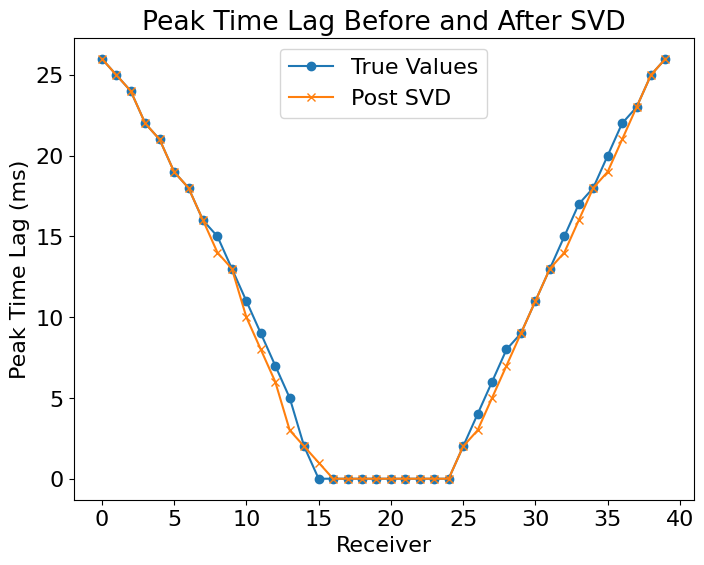

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
rmse = np.sqrt(mean_squared_error(peak_timelag, peak_timelag_postSVD))
print(f"RMSE: {rmse}")

# 2. MAE (Mean Absolute Error)
mae = mean_absolute_error(peak_timelag, peak_timelag_postSVD)
print(f"MAE: {mae}")

# 3. Correlation Coefficient (Pearson Correlation)
correlation = np.corrcoef(peak_timelag, peak_timelag_postSVD)[0, 1]
print(f"Correlation Coefficient: {correlation}")

r2 = r2_score(peak_timelag, peak_timelag_postSVD)
print(f"R-Squared: {r2}")

# 4. Visualization: Plot the True vs Predicted Values
plt.plot(peak_timelag, label="True Values", marker='o')
plt.plot(peak_timelag_postSVD, label="Post SVD", marker='x')
plt.legend()
plt.title("Peak Time Lag Before and After SVD")
plt.xlabel("Receiver")
plt.ylabel("Peak Time Lag (ms)")
plt.show()

In [15]:
rmse = np.sqrt(mean_squared_error(averaged_cross_correlation, averaged_cross_correlation_postSVD))
print(f"RMSE: {rmse}")

# 2. MAE (Mean Absolute Error)
mae = mean_absolute_error(averaged_cross_correlation, averaged_cross_correlation_postSVD)
print(f"MAE: {mae}")

# 3. Correlation Coefficient (Pearson Correlation)
correlation = np.corrcoef(averaged_cross_correlation, averaged_cross_correlation_postSVD)[0, 1]
print(f"Correlation Coefficient: {correlation}")

RMSE: 0.0001174941797616522
MAE: 5.951385953917307e-05
Correlation Coefficient: 0.9694630496672159
